## Feature Engineering
Once the data has been profiled, with any obvious defects having been addressed, the next activity is to potentially enhance the data's ability to produce effective machine learning models. The single greatest opportunity for doing so involves techniques that are aimed at enhancing the patterns inherent (or hidden), within the sample data. For example, a sample may include a datetime feature. In their raw form, datetime features may show little correlation to other features or the target.  However, dataparts like Year, Month, DayOfWeek, HourOfDay and whether a particular day is a WeekDay, WeekEndDay, or a Holiday may show significant correlation. Therefore, in such a case it would be advantageous to "extract" that information from the raw DateTime feature.

#### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
#from sklearn.preprocessing import OneHotCategoricalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer

#### Define Global Functions

In [2]:
def double_plots(df, col):
    # function to plot a histogram and a Q-Q plot side by side, for a certain variable
    plt.figure(figsize=(10, 4.5))
    plt.subplot(1, 2, 1)
    df[col].hist(bins=30)
    plt.subplot(1, 2, 2)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.show()
    
def triple_plots(df, col):
    # function to plot a histogram, a Q-Q plot and a Boxplot side-by-side.
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    sns.distplot(df[col], bins=30)
    #sns.displot(data=df, x=df[col], kde=True)
    plt.title('Histogram')
    plt.subplot(1, 3, 2)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.ylabel(f"{col} quantiles")
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[col])
    plt.title('Boxplot')
    plt.show()
    
def before_and_after_plots(df, cols, titles):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

    ax1.set_title(titles[0])
    for col in cols:
        sns.kdeplot(data=df[col], ax=ax1)

    ax2.set_title(titles[1])
    for col in cols:
        sns.kdeplot(data=df[col], ax=ax2)

    plt.show()

#### Import the Data 

In [3]:
data_dir = os.path.join(os.getcwd(), 'Data')
source_data_file = 'titanic-eda.csv';

data_file = os.path.join(data_dir, source_data_file)
df = pd.read_csv(data_file, header=0, index_col=0)

# Ensure the index values are: seed=1, increment=1
df.reset_index(drop=True, inplace=True)

print(f"Shape: {df.shape[0]} Observations x {df.shape[1]} Features")

Shape: 1307 Observations x 17 Features


#### Modify the Data Type of Categorical Features Having Numerical Values

In [4]:
df[['survived','sibsp','parch']] = df[['survived','sibsp','parch']].astype('object')
df.dtypes

age              float64
fare             float64
body             float64
cabin             object
embarked          object
home.dest         object
boat              object
cabin_NA            bool
embarked_NA         bool
boat_NA             bool
home.dest_NA        bool
survived          object
sex               object
sibsp             object
parch             object
ticket            object
survived_desc     object
dtype: object

#### Separate Numerical and Categorical Features

In [5]:
numerical_cols = [col for col in df.columns if df.dtypes[col] != 'O' and df.dtypes[col] != bool]
categorical_cols = [col for col in df.columns if col not in numerical_cols and df.dtypes[col] != bool]
cat_missing_cols = [col for col in df.columns if df.dtypes[col] == bool]

print(f"{df[numerical_cols].shape[1]} Numericals: {numerical_cols}") 
print(f"{df[categorical_cols].shape[1]} Categoricals: {categorical_cols}")
print(f"{len(cat_missing_cols)} Missing Value Indicators: {cat_missing_cols}")

3 Numericals: ['age', 'fare', 'body']
10 Categoricals: ['cabin', 'embarked', 'home.dest', 'boat', 'survived', 'sex', 'sibsp', 'parch', 'ticket', 'survived_desc']
4 Missing Value Indicators: ['cabin_NA', 'embarked_NA', 'boat_NA', 'home.dest_NA']


## Section I: Improving Existing Features

### 1.0 Handling Outliers
One outcome of data profiling is the identification of outliers. Before considering any further feature engineering activities it would be advantageous to consider how any outliers should be handled. Because parameters like mean, variance and standard deviation are all sensitive to outliers, some subsequent activities (e.g., scaling or transforming numericals) may be impacted by the current distribution of values in the affected features. Fundamentally, there are two approaches to handling outliers; exclusion (trimming) or engineering. The choice is primarily driven by whether or not those outliers represent erroneously entered values. If the values represent the general truth then it may not be advantageous to remove them.

Outliers can be engineered using a number of approaches. One way is to perform **variable discretization** whereby outliers will fall into the upper and/or lower categories. Another approach involves rendering outlying tuples as *null* so they will be treated as missing data when any imputation techniques are applied to handle missing data. Outliers can also be replaced by predetermined minimum and/or maximum values. Finally, in a process called **winsorization**, the mean and standard deviation, or the inter-quartile range or percentiles, can be used to treat parametric (normal) or non-paramtric (skewed) features.

##### First, Inspect the Distribution of the Variable In-Question

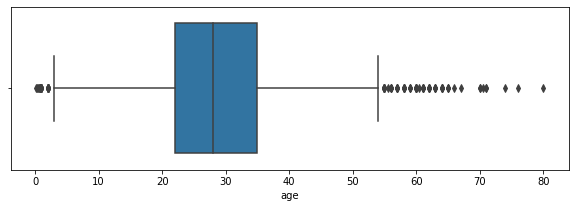

In [6]:
plt.figure(figsize=(10,3))
sns.boxplot(x=df.age)
plt.show()

#### 1.1. Trimming
Three techniques are available to determine the boundaries beyond which a value will be considered an outlier. First, when working with parametric (normally distributed) variables, the 3rd standard deviation (positive or negative) will encompass 99% of the sample; therefore, any values beyond those boundaries can be trimmed. Second, when working with either parametric or non-parametric variables, the inter-quartile range proximity rule can be used to define upper and lower boundaries. Finally, also applicable to both normal and non-normal variables, is arbitrarily setting the boundaries at the 5th and 95th quartiles.

##### 1.1.1. Using the Mean and (3rd) Standard Deviation

In [7]:
def std_bounds(df, col, distance):
    lbound = df[col].mean() - (df[col].std() * distance)
    ubound = df[col].mean() + (df[col].std() * distance)
    return ubound, lbound

In [8]:
df_copy = df[numerical_cols].copy()

age_ubound, age_lbound = std_bounds(df_copy, 'age', 1.5)
outliers_age = np.where(df_copy.age > age_ubound, True, np.where(df_copy.age < age_lbound, True, False))

df_trimmed = df_copy.loc[~outliers_age]
df_copy.shape, df_trimmed.shape

((1307, 3), (1102, 3))

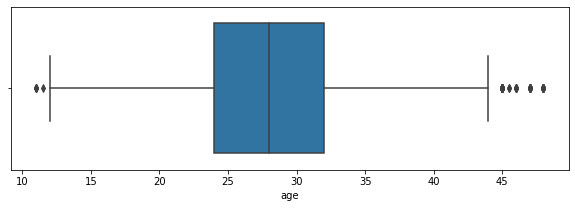

In [9]:
plt.figure(figsize=(10,3))
sns.boxplot(x=df_trimmed.age)
plt.show()

##### 1.1.2. Using the Inter-Quartile Proximity Rule

In [10]:
def iqr_bounds(df, col, distance):
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    lbound = df[col].quantile(0.25) - (IQR * distance)
    ubound = df[col].quantile(0.75) + (IQR * distance)
    return ubound, lbound

In [11]:
df_copy = df[numerical_cols].copy()

age_ubound, age_lbound = iqr_bounds(df_copy, 'age', 1.5)
outliers_age = np.where(df_copy.age > age_ubound, True, np.where(df_copy.age < age_lbound, True, False))

df_trimmed = df_copy.loc[~outliers_age]
df_copy.shape, df_trimmed.shape

((1307, 3), (1206, 3))

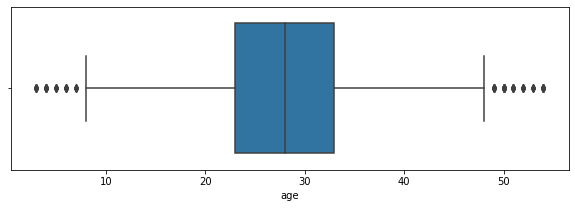

In [12]:
plt.figure(figsize=(10,3))
sns.boxplot(x=df_trimmed.age)
plt.show()

##### 1.1.3. Using the 5th and 95th Quartiles

In [13]:
def arb_bounds(df, col):
    lbound = df[col].quantile(0.05)
    ubound = df[col].quantile(0.95)
    return ubound, lbound

In [14]:
df_copy = df[numerical_cols].copy()

age_ubound, age_lbound = arb_bounds(df_copy, 'age')
outliers_age = np.where(df_copy.age > age_ubound, True, np.where(df_copy.age < age_lbound, True, False))

df_trimmed = df_copy.loc[~outliers_age]
df_copy.shape, df_trimmed.shape

((1307, 3), (1182, 3))

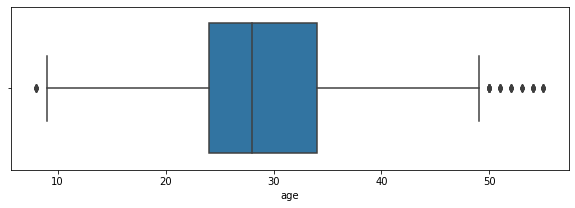

In [15]:
plt.figure(figsize=(10,3))
sns.boxplot(x=df_trimmed.age)
plt.show()

#### 1.2. Winsorization

In [16]:
def winsorize(df, col, ubound, lbound):
    return np.where(df[col] > ubound, ubound, np.where(df[col] < lbound, lbound, df[col]))

In [17]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = winsorize(df_copy, 'age', df_copy.age.quantile(0.95), df_copy.age.quantile(0.05))

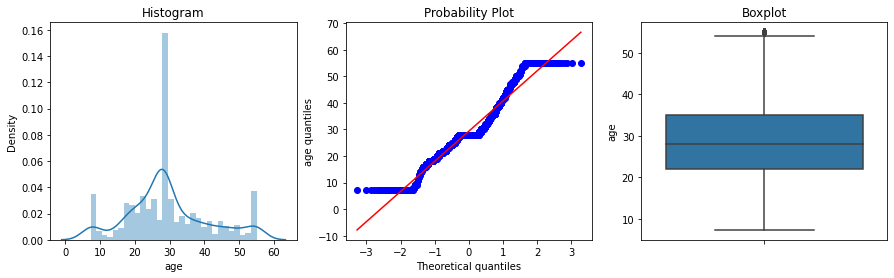

In [18]:
triple_plots(df_copy, 'age')

#### 1.3. Capping at Arbitrary Maximum and Minimum Values

In [19]:
def skewed_bounds(df, col, distance):
    # Use the IRQ Proximity Rule for Non-Parametric features
    ubound, lbound = iqr_bounds(df, col, distance)

    return ubound, lbound

def normal_bounds(df, col, distance):
    # Use Mean & Std for Parametric features
    ubound, lbound = std_bounds(df, col, distance)

    return ubound, lbound

In [20]:
df_copy = df[numerical_cols].copy()

age_ubound, age_lbound = skewed_bounds(df_copy, 'age', 3)

df_copy['age'] = np.where(df_copy['age'] > age_ubound, age_ubound,
                       np.where(df_copy['age'] < age_lbound, age_lbound, df_copy['age']))

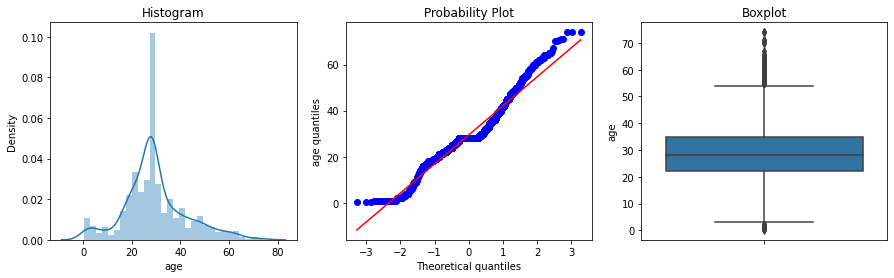

In [21]:
triple_plots(df_copy, 'age')

#### 1.4 Zero-coding: Capping Values at Zero

In [22]:
def zero_bound(df, col):
    return np.where(df[col] < 0, True, False)

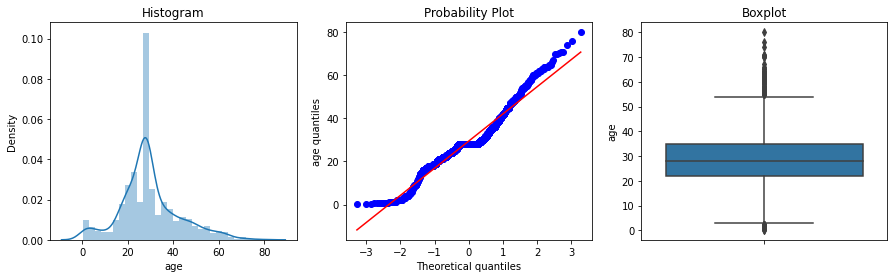

In [23]:
df_copy = df[numerical_cols].copy()

outliers_age = zero_bound(df_copy, 'age')
df_trimmed = df_copy.loc[~outliers_age]

triple_plots(df_trimmed, 'age')

### 2.0 Scaling Numerical Features
Numerical features (variables) are those datum having continuous numeric values (e.g., float or decimal types).  As such, each numerical feature is likely to exhibit an unique range of values that may or may not contain both positive and negative values. Some machine learning algorithms are better equipt to cope with multiple features having different ranges than are others.  It is customary, if not altogether necessary, to transform each numerical feature in a collection of independent features so that they conform to a predetermined range (e.g., between 0 and 1, or having a mean of 0 (zero) and a standard deviation of 1 (one)).

#### 2.1 Standardization
Standardization transforms the values of a numerical feature so they have a mean of 0 (zero) and a standard deviation of 1 (one).

##### Using Scikit-Learn

In [24]:
df_copy = df[numerical_cols].copy()

scaler = StandardScaler()
scaler.fit(df_copy)
arr_scaled = scaler.transform(df_copy)

print(f"Mean of the Features: {scaler.mean_ }")
print(f"Standard Deviation of the Features: {scaler.scale_}")

df_scaled = pd.DataFrame(arr_scaled, columns=df_copy.columns)

Mean of the Features: [ 29.49171132  33.33442229 160.80889497]
Standard Deviation of the Features: [12.903941   51.7490731  29.60288931]


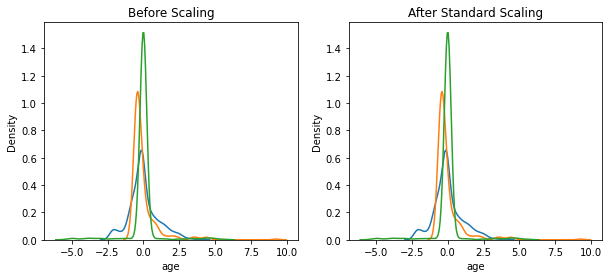

In [25]:
columns = ['age','fare','body']
titles = ['Before Scaling','After Standard Scaling']

before_and_after_plots(df_scaled, columns, titles)

#### 2.2 Mean Normalization
Mean normalization centers the feature at 0 (zero), and re-scales to the value range. The formula subtracts the mean of each observation and divides by the difference between the minimum and maximum value: **X_scaled = (X - X.mean) / (X.max - X.min)**

##### Using Pandas

In [26]:
df_copy = df[numerical_cols].copy()

means = df_copy.mean(axis=0)
ranges = df_copy.max(axis=0)-df_copy.min(axis=0)

df_scaled = (df_copy - means)/ranges

##### Using Scikit-Learn

In [27]:
scaler_mean = StandardScaler(with_mean=True, with_std=False)
scaler_mean.fit(df_copy)
scaler_minmax = RobustScaler(with_centering=False, with_scaling=True, quantile_range=(0,100))
scaler_minmax.fit(df_copy)

arr_normed = scaler_minmax.transform(scaler_mean.transform(df_copy))
df_normed = pd.DataFrame(data=arr_normed, columns=df_copy.columns)

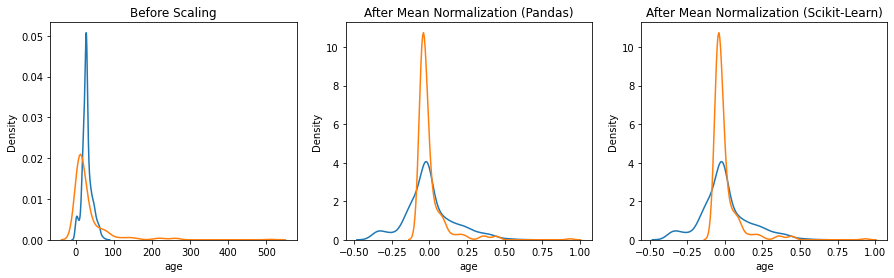

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,4))

ax1.set_title("Before Scaling")
sns.kdeplot(data=df_copy.age, ax=ax1)
sns.kdeplot(data=df_copy.fare, ax=ax1)

ax2.set_title("After Mean Normalization (Pandas)")
sns.kdeplot(data=df_scaled.age, ax=ax2)
sns.kdeplot(data=df_scaled.fare, ax=ax2)

ax3.set_title("After Mean Normalization (Scikit-Learn)")
sns.kdeplot(data=df_normed.age, ax=ax3)
sns.kdeplot(data=df_normed.fare, ax=ax3)

plt.show()

#### 2.3 MinMax Scaling
Minimum and Maximum Scaling compresses all values in the distribution between 0 (zero) and 1 (one). The formula subracts the the minimum value from all the observation, and then divides it by the value range: **X_scaled = (X - X.min / (X.max - X.min))**.

##### Using Scikit-Learn

In [29]:
df_copy = df[numerical_cols].copy()

scaler = MinMaxScaler()
scaler.fit(df_copy)
arr_scaled = scaler.transform(df_copy)

print(f"Maximum of the Features: {scaler.data_max_}")
print(f"Minumum of the Features: {scaler.min_}")
print(f"Data Range: {scaler.data_range_}")

df_scaled = pd.DataFrame(arr_scaled, columns=df_copy.columns)

Maximum of the Features: [ 80.     512.3292 328.    ]
Minumum of the Features: [-0.0020881  0.        -0.0030581]
Data Range: [ 79.8333 512.3292 327.    ]


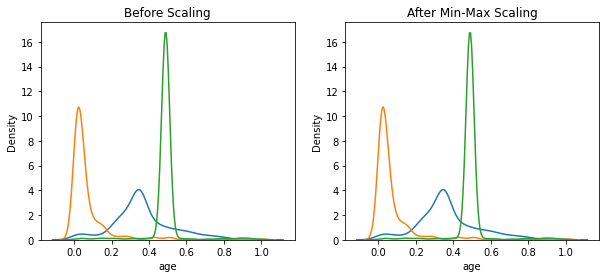

In [30]:
columns = ['age','fare','body']
titles = ['Before Scaling','After Min-Max Scaling']

before_and_after_plots(df_scaled, columns, titles)

#### 2.4.1. Maximum Absolute Scaling
Maximum absolute scaling scales the data to its maximum value: **X_scaled = X / X.max**

In [31]:
df_copy = df[numerical_cols].copy()

scaler = MaxAbsScaler()
scaler.fit(df_copy)
arr_scaled = scaler.transform(df_copy)

print(f"Absolute Maximum of the Features: {scaler.max_abs_}")

df_scaled = pd.DataFrame(arr_scaled, columns=df_copy.columns)

Absolute Maximum of the Features: [ 80.     512.3292 328.    ]


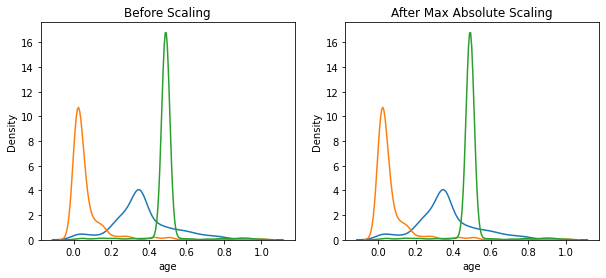

In [32]:
columns = ['age','fare','body']
titles = ['Before Scaling','After Max Absolute Scaling']

before_and_after_plots(df_scaled, columns, titles)

#### 2.4.2. Centering + MaxAbsScaling
Distributions can be centered at 0 (zero) before being scaled to its absolute maximum.

In [33]:
df_copy = df[numerical_cols].copy()

scaler_mean = StandardScaler(with_mean=True, with_std=False)
scaler_maxabs = MaxAbsScaler()

scaler_mean.fit(df_copy)
scaler_maxabs.fit(df_copy)

arr_scaled = scaler_maxabs.transform(scaler_mean.transform(df_copy))

df_scaled = pd.DataFrame(arr_scaled, columns=df_copy.columns)

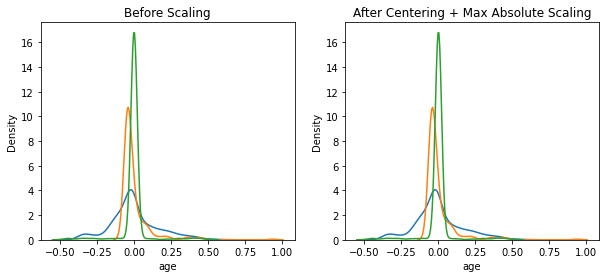

In [34]:
columns = ['age','fare','body']
titles = ['Before Scaling','After Centering + Max Absolute Scaling']

before_and_after_plots(df_scaled, columns, titles)

#### 2.5 Robust Scaling (Scaling with the Median and Quantiles)
Robust scaling produces more robust estimates for the center and value range of the feature, and is less sensitive to outliers. This is achieved by scaling variables to the median and quantiles (i.e., the median value is removed from the sample and the result is divided by the inter-quartile range (IQR)).

In [35]:
df_copy = df[numerical_cols].copy()

scaler = RobustScaler()
scaler.fit(df_copy)
arr_scaled = scaler.transform(df_copy)

print(f"Median Values: {scaler.center_}")
print(f"IQR Values of the Features: {scaler.scale_}")

df_scaled = pd.DataFrame(arr_scaled, columns=df_copy.columns)

Median Values: [ 28.          14.4542     160.82385071]
IQR Values of the Features: [1.30000000e+01 2.33792000e+01 2.28565073e-02]


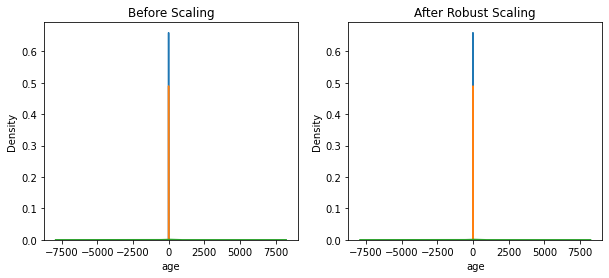

In [36]:
columns = ['age','fare','body']
titles = ['Before Scaling','After Robust Scaling']

before_and_after_plots(df_scaled, columns, titles)

#### 2.6. Scaling to Vector Unit Length
When scaling to vector unit length, the components of a feature vector are transformed so that the transformed vector has a length of 1 (i.e., a norm of 1). This scaling technique scales the feature vector, rather than each individual variable. A feature vector contains the values of each variable for a single observation. When scaling to vector unit length, we divide each feature vector by its norm.

Scaling to the unit norm is achieved by dividing each observation vector by either the Manhattan distance (l1 norm) or the Euclidean distance (l2 norm).
- The Manhattan distance is given by the sum of the absolute components of the vector: **l1(X) = |x1| + |x2| + ... + |xn|**
- Whereas the Euclidean distance is given by the square root of the square sum of the component of the vector: **l2(X) = sqr( x1^2 + x2^2 + ... + xn^2 )**

#### 2.6.1. Scaling to I1

In [37]:
df_copy = df[numerical_cols].copy()

scaler = Normalizer(norm='l1')
scaler.fit(df_copy)

arr_scaled = scaler.transform(df_copy)

##### Calculate the l1 Norm for each Observation: Original Data

In [38]:
np.round(np.linalg.norm(df_copy, ord=1, axis=1), 1)

array([401. , 313.2, 314.3, ..., 337.7, 195.1, 197.7])

##### Calculate the l1 Norm for each Observation: Scaled Data

In [39]:
np.round(np.linalg.norm(arr_scaled, ord=1, axis=1), 1)

array([1., 1., 1., ..., 1., 1., 1.])

##### 2.6.2. Scaling to I2

In [40]:
df_copy = df[numerical_cols].copy()

scaler = Normalizer(norm='l2')
scaler.fit(df_copy)

arr_scaled = scaler.transform(df_copy)

##### Calculate the l2 Norm for each Observation: Original Data

In [41]:
np.round(np.linalg.norm(df_copy, ord=1, axis=1), 1)

array([401. , 313.2, 314.3, ..., 337.7, 195.1, 197.7])

##### Calculate the l2 Norm for each Observation: Scaled Data

In [42]:
np.round(np.linalg.norm(arr_scaled, ord=1, axis=1), 1)

array([1.5, 1.4, 1.4, ..., 1.1, 1.2, 1.2])

### 3.0. Transforming Numerical Features
A number of machine learning algorithms, like Logistic Regression (for classification) and Linear Regression, assume that the features are parametric (normally distributed); however, source data may not satisfy this assumption. Fortunately there are a number of mathematical transformations that can be used to engineer non-parametric features to conform to a parametric (normal or gaussian) distribution. What's more, these transformations often reveal linear relationships that may exist between those predictors (independent variables) and the response (dependend variable or Target). Ergo, these transformations may improve the efficacy of the resulting model. Among these mathematical transformations are the logarithm, reciprocal, power, square and cube root, Box-Cox, and Yeo-Johnson transformations. It is important to note that these tranformations should be applied to complete data; i.e., any missing data should have already either been excluded or imputed.

##### Ensure there are no missing values

In [43]:
df[numerical_cols].isnull().sum().sort_values(ascending=True)

age     0
fare    0
body    0
dtype: int64

##### Inspect the Distribution Before Transformation:

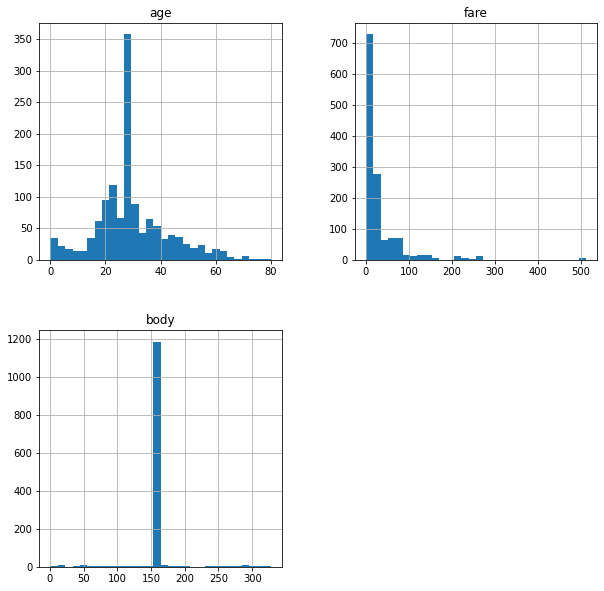

In [44]:
df[numerical_cols].hist(bins=30, figsize=(10,10))
plt.show()

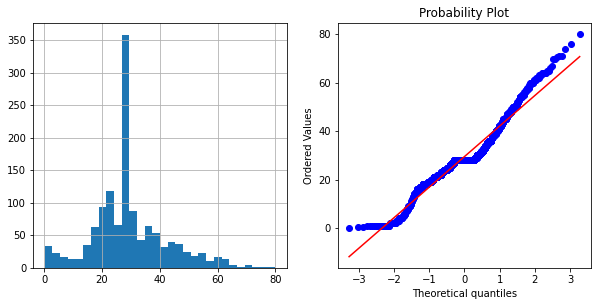

In [45]:
double_plots(df, 'age')

#### 3.1 Logarithmic Transformation
##### Using NumPy

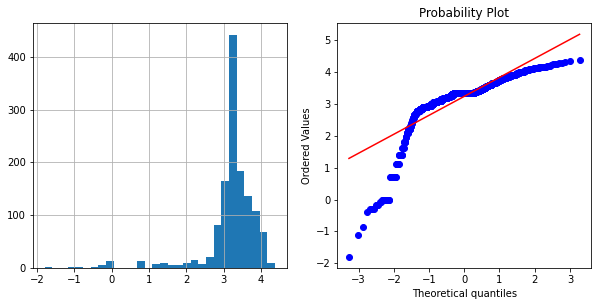

In [46]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = np.log(df_copy.age)

double_plots(df_copy, 'age')

##### Using Scikit-Learn

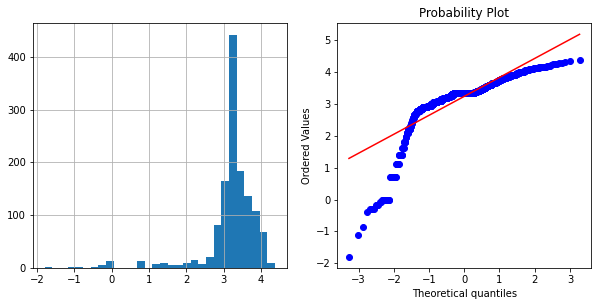

In [47]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(np.log, validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

double_plots(df_trn, 'age')

#### 3.2. Reciprocal Transformation
##### Using NumPy

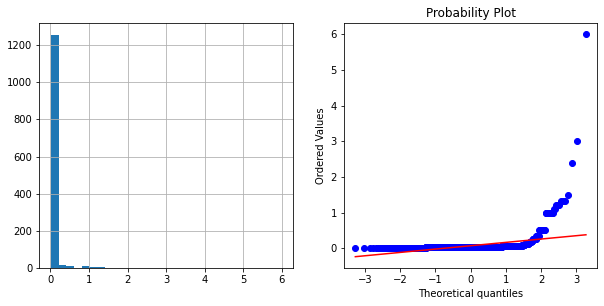

In [48]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = np.reciprocal(df_copy.age)

double_plots(df_copy, 'age')

##### Using Scikit-Learn

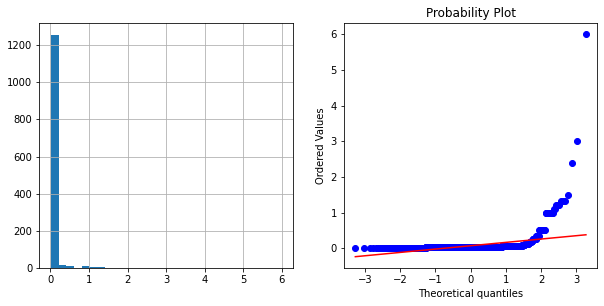

In [49]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(np.reciprocal, validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

double_plots(df_trn, 'age')

#### 3.3. Square/Cube Root Transformation
##### Using NumPy

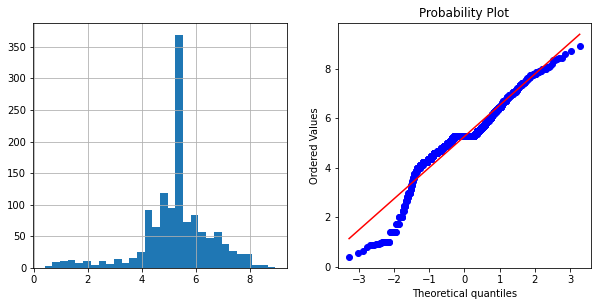

In [50]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = np.sqrt(df_copy.age)

double_plots(df_copy, 'age')

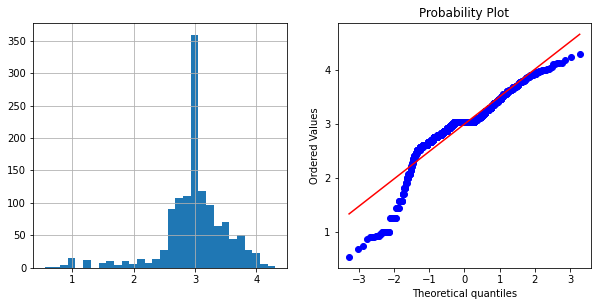

In [51]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = np.cbrt(df_copy.age)

double_plots(df_copy, 'age')

##### Using Scikit-Learn

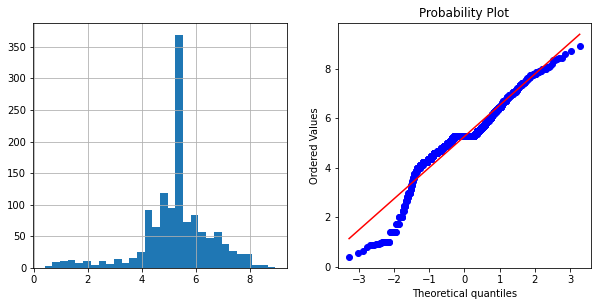

In [52]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(np.sqrt, validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

double_plots(df_trn, 'age')

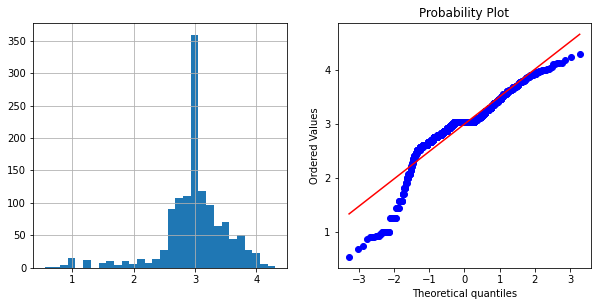

In [53]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(np.cbrt, validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

double_plots(df_trn, 'age')

#### 3.4. Power (Exponential) Transformation
##### Using NumPy

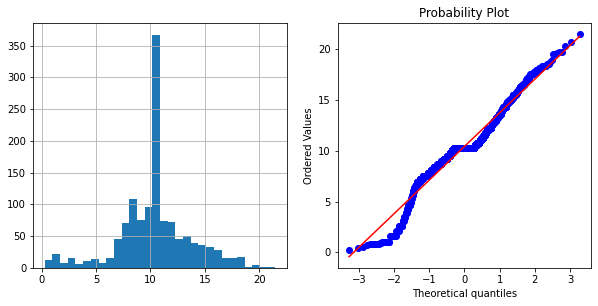

In [54]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = np.power(df_copy.age, 0.7)

double_plots(df_copy, 'age')

##### Using Scikit-Learn

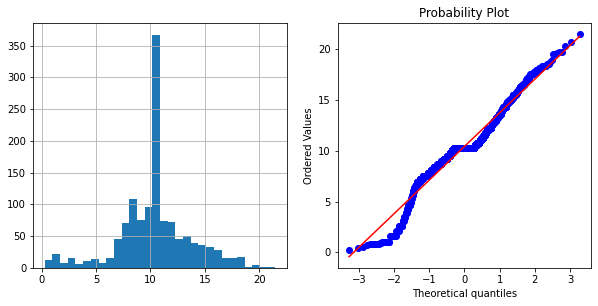

In [55]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(lambda x: np.power(x, 0.7), validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

double_plots(df_trn, 'age')

#### 3.5. Box-Cox Transformation
##### Using SciPy

Optimal Lambda:  0.7870405436135359


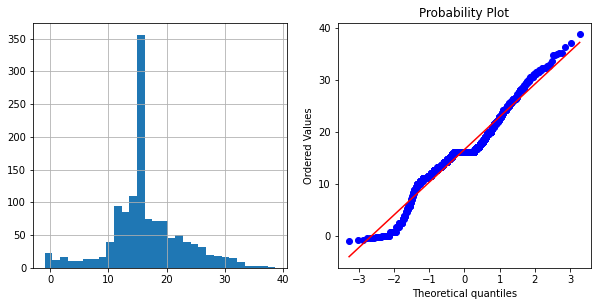

In [56]:
df_copy = df[numerical_cols].copy()
df_copy['age'], param = stats.boxcox(df_copy.age)

print('Optimal Lambda: ', param)
double_plots(df_copy, 'age')

##### Using Scikit-Learn

In [57]:
#df_copy = df[numerical_cols].copy()

#transformer = PowerTransformer(method='box-cox', standardize=True)
#transformer.fit(df_copy)

#df_trn = transformer.transform(df_copy)
#df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

#print(f"Lambdas: {transformer.lambdas_}")
#double_plots(df_trn, 'age')

#### 3.6. Yeo-Johnson Transformation
##### Using SciPy

Optimal Lambda:  0.7785774167890672


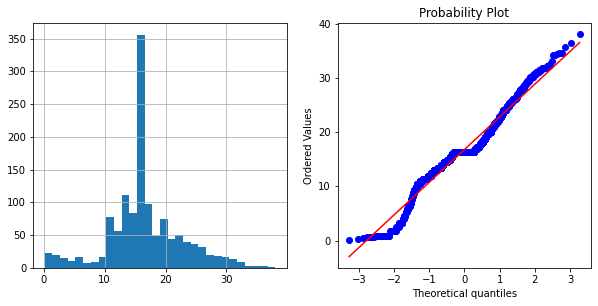

In [58]:
df_copy = df[numerical_cols].copy()
df_copy['age'], param = stats.yeojohnson(df_copy.age)

print('Optimal Lambda: ', param)
double_plots(df_copy, 'age')

##### Using Scikit-Learn

Lambdas: [ 0.77857742 -0.14030257  1.15872008]


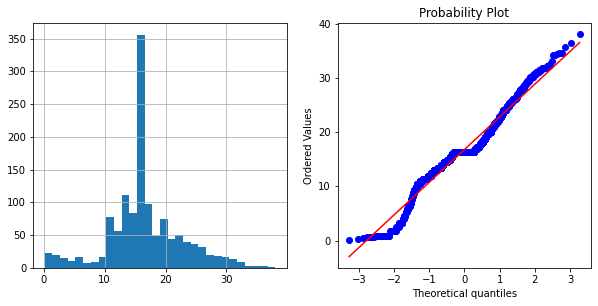

In [59]:
df_copy = df[numerical_cols].copy()

transformer = PowerTransformer(method='yeo-johnson', standardize=False)
transformer.fit(df_copy)

df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

print(f"Lambdas: {transformer.lambdas_}")
double_plots(df_trn, 'age')

### 4.0. Encoding Categorical Features
Categorical features (variables) are those datum having discrete values (rather than contiunous numerical values) where each unique value represents some member or level of the specified category. What's more, categorical features may reflect datum having a natural order (e.g., Size: Small, Medium or Large), or may exhibit no such natural ordering (e.g., Fruit: Apple, Orange, or Banana).  The former are designated **Ordinal** Categorical Variables whereas the latter are designated **Nominal** Categorical Variables. In any case, machine learning algorithms aren't typically well equipt to cope with text-based labels; therefore, it is both customary and necessary to translate these text-based labels into some form of numerical representation in order for machine learning algorithms to learn from them effectively.
#### 4.1. One-Hot Encoding
Sometimes called "dummy encoding", one-hot encoding is most appropriate for representing **nominal** categorical features because it is unable to denote any ordering of the values it represents. One-hot encoding transforms a categorical variable by creating a new group of binary variables where each member in the group represents each unique value (category) contained in the original variable. For each observation, only one of the new variables will contain the value 1 (one) as it corresponds to the value present in that observation while all other variables in the group will contain the value 0 (zero) to signify the absense of that value in the observation; hence, one is **"hot"** while the others are **not**.  For example, if a feature (variable) named "Color" contains the values "Red", "Green" and "Blue", then one-hot encoding would create three new features named "Red", "Green" and "Blue". Subsequently, where in a specific observation the feature named "Color" contains the value "Green", the new varable named "Green" would contain the value 1 (one) while the new variables named "Red" and "Blue" would both contain the value 0 (zero).

##### 4.1.1. One-Hot Encoding Using Pandas

In [60]:
df.sex.unique()

array(['female', 'male'], dtype=object)

In [61]:
ohe_sex = pd.get_dummies(df.sex, drop_first=False)
ohe_sex.head()

,female,male
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0


##### Alternate: k-1 One-Hot Encoding
For the sake of reducing the dimensionality of the newly created group of binary variables, a categorical variable with *k* unique categories can be encoded using *k-1* binary variables. Extending our "Color" example, it is possible to accurately represent this feature using only 2 binary variables (e.g., Green and Blue). If the feature contained the value "Green" then the variable "Green" would be 1 (one) with the variable "Blue" being 0 (zero). If the feature contained the value "Blue" then the reverse would be true.  However, if the feature contained the value "Red" then both "Green" and "Blue" would contain the value 0 (zero).

In [62]:
k1_ohe_sex = pd.get_dummies(df.sex, drop_first=True)
k1_ohe_sex.head()

,male
0,0
1,1
2,0
3,1
4,0


##### 4.1.2. One-Hot Encoding Using Scikit-Learn

In [63]:
cats = df[categorical_cols].drop(['ticket'], axis=1)
cats.nunique()

cabin            181
embarked           3
home.dest        369
boat              28
survived           2
sex                2
sibsp              7
parch              8
survived_desc      2
dtype: int64

In [64]:
oh_encoder = OneHotEncoder(categories='auto', sparse=False) # returns k dummies.
oh_encoder.fit(cats)

ohe_cats = oh_encoder.transform(cats)

In [65]:
pd.DataFrame(ohe_cats).head()

,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,600,601
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##### Alternate: k-1 One-Hot Encoding

In [66]:
k1_oh_encoder = OneHotEncoder(categories='auto', sparse=False, drop='first') # returns k-1 dummies.
k1_oh_encoder.fit(cats)

k1_ohe_cats = k1_oh_encoder.transform(cats)

In [67]:
pd.DataFrame(k1_ohe_cats).head()

,0,1,2,3,4,5,6,7,8,9,...,583,584,585,586,587,588,589,590,591,592
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


##### 4.1.3. One-Hot Encoding of Most Frequent Categories
Since One-Hot Encoding represents each category that's contained by a categorical feature as a new feature, this encoding technique can quickly expand the dimensionality (i.e., the number of features) of a dataset if the feature being encoded is highly cardinal (i.e., has many unique values). This issue can be addressed by selectively discretizing those categories (values). The most frequently occurring categories can be represented by unique binary features per the customary one-hot encoding technique while those categories having few occurances can be grouped into a smaller number of additional binary features where each feature represents some logical range of values.

##### First, Determine the Cardinality of the Feature, and then Inspect its Value Distribution

In [68]:
feature = 'home.dest'

df[feature].nunique()

369

In [69]:
df[feature].value_counts().sort_values(ascending=False)

New York, NY                  627
London                         14
Montreal, PQ                   10
Paris, France                   9
Cornwall / Akron, OH            9
                             ... 
Southampton / New York, NY      1
Elmira, NY / Orange, NJ         1
Middleburg Heights, OH          1
Bennington, VT                  1
Milford, NH                     1
Name: home.dest, Length: 369, dtype: int64

##### Next, Create a List Containing its Top 'n' Categories, and Use it to Create a Binary Variable for Each Category

In [70]:
n = 3

top_n = [x for x in df[feature].value_counts().sort_values(ascending=False).head(n).index]
top_n

['New York, NY', 'London', 'Montreal, PQ']

In [71]:
for label in top_n:
    df[feature + '_' + label] = np.where(df[feature] == label, 1, 0)
    
df[[feature] + [feature + '_' + c for c in top_n]].head(6)

,home.dest,"home.dest_New York, NY",home.dest_London,"home.dest_Montreal, PQ"
0,"St Louis, MO",0,0,0
1,"Montreal, PQ / Chesterville, ON",0,0,0
2,"Montreal, PQ / Chesterville, ON",0,0,0
3,"Montreal, PQ / Chesterville, ON",0,0,0
4,"Montreal, PQ / Chesterville, ON",0,0,0
5,"New York, NY",1,0,0


#### 4.2. Ordinal Encoding

#### 4.3 Frequency Encoding or Count Encoding
These encoding techniques add weighting to the **value** used to encode a categorical feature by replacing each category with either its count or the percentage (frequency) of observations it represents within that features distribution.  For example, consider a sample having 100 observations that contains a categorical feature named **Color** which contains 20 Red, 50 Green, and 30 Blue categories. Frequency Encoding would replace Red observations with 0.2, Green with 0.5, and Blue with 0.3.  Count Encoding with replace Red with 20, Green with 50, and Blue with 30. The motivation for this technique is that the proportion of each category contributes significantly towards predicting the *Target*.

##### 4.3.1. Count Encoding
##### First, Create a Dictionary to Capture the Count of Observations per Category

In [72]:
column = 'parch'
df_copy = df[categorical_cols].copy()

count_map = df_copy[column].value_counts().to_dict()
count_map

{0: 1000, 1: 170, 2: 113, 3: 8, 4: 6, 5: 6, 6: 2, 9: 2}

##### Next, Replace Each Category with the Count of its Observations

In [73]:
col_enc = 'parch_enc'
df_copy[col_enc] = df[column].map(count_map)

df_copy[[column, col_enc]].head()

,parch,parch_enc
0,0,1000
1,2,113
2,2,113
3,2,113
4,2,113


##### 4.3.2. Fequency Encoding
Frequency encoding is achieved simply by dividing the value count by the total number (count) of observations. Here the algorithm will be codified into two functions; one to create the mapping, and one to create the encoded feature.

In [74]:
df_copy = df[categorical_cols].copy()

col_name = 'parch'
enc_col_name = 'parch_freq'

def frequency_mappings(df, feature):
    return (df[feature].value_counts()/df.shape[0]).to_dict()

def encode(df, feature, mapping):
    return df[feature].map(mapping)

freq_map = frequency_mappings(df_copy, col_name)
display(freq_map)

df_copy[enc_col_name] = encode(df_copy, col_name, freq_map)
df_copy[[col_name, enc_col_name]].head()

{0: 0.7651109410864575,
 1: 0.13006885998469778,
 2: 0.0864575363427697,
 3: 0.00612088752869166,
 4: 0.0045906656465187455,
 5: 0.0045906656465187455,
 6: 0.001530221882172915,
 9: 0.001530221882172915}

,parch,parch_freq
0,0,0.765111
1,2,0.086458
2,2,0.086458
3,2,0.086458
4,2,0.086458


## Section II: Creating New Features
### 5.0. Variable Discretization
Continuous numerical features can often encompass a broad range with many increments. Many times the organic level of granularity has little impact on its influence, and may only serve to hinder the its interpretability. For example, a feature many reflect the **Age** of some person or thing where the feature contains a continuum of ages (e.g., 22, 23, 24... 65, 66, 67). In most cases the feature can be *engineered* so that it reflects decades (e.g., 20's, 30's, 40's, 50's) such that it is inherently more clear and understandable, and in many cases so that is may actually be more influetial against the *Target*.

### 6.0. Deriving Features from DateTime Variables

### 7.0. Deriving Features by Mathematical Computation

### 8.0. Extracting Features from Text Variables
It's not uncommon to encounter features containing unstructured text. Examples include product descriptions, customer reviews or feedback, notes taken by customer service reps or insurance claims adjusters, etc. Unlike the values typically found in structured (tabular) data, unstructured text does not follow a predetermined pattern; i.e., it can vary in its length, content, vernacular and writing style. The unstructured nature of these features present an unique challenge with regards to extracting useful information, or in other words, variable(s) that would consistently influence the efficacy of a machine learning model.

Feature engineering in this domain is accommplished via **Natural Language Processing (NLP)**; an aspect of data science that's concerned with interpreting or understanding human language. This section will only briefly address this topic for the sake of introducing techniques and software required to extract useful features from unstructured text.

### 9.0. Creating Features with Transactional & Time-Series Data